In [236]:
%matplotlib inline
import math
import torch
import torchvision
from d2l import torch as d2l
d2l.use_svg_display()

In [237]:
data_transoform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  lambda x: torch.floor(x * 255 / 128).squeeze(dim=0)
])

mnist_train = torchvision.datasets.MNIST(
  root="./temp", train=True, transform=data_transoform, download=True
)

mnist_test = torchvision.datasets.MNIST(
  root="./temp", train=False, transform=data_transoform, download=True
)

In [238]:
image, label = mnist_train[2]
image.shape, label

(torch.Size([28, 28]), 4)

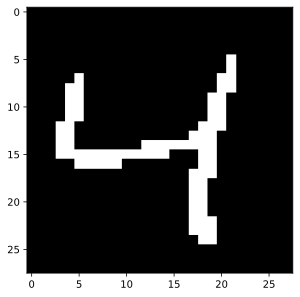

In [239]:
d2l.plt.imshow(image, cmap=d2l.plt.cm.gray)

In [240]:
image.unique()

tensor([0., 1.])

In [241]:
images = torch.stack([mnist_train[i][0] for i in range(10, 38)], dim=0)
labels = torch.tensor([mnist_train[i][1] for i in range(10, 38)])

images.shape, labels.shape

(torch.Size([28, 28, 28]), torch.Size([28]))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

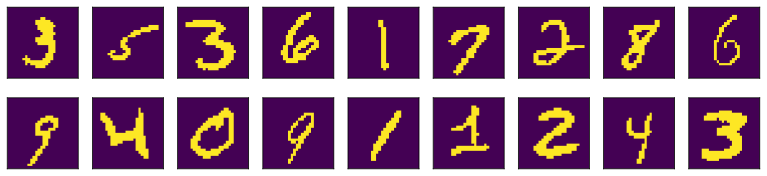

In [242]:
d2l.show_images(images, 2, 9)

In [243]:
p_y_len = mnist_train.train_labels.unique().size(0)
p_y = torch.zeros(p_y_len)


In [244]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [245]:
d = mnist_train.data.shape[1] * mnist_train.data.shape[2]
d

784

In [246]:
test_x = mnist_train[1][0].flatten()
test_x.shape

torch.Size([784])

In [247]:
p_xy = torch.zeros((test_x.shape[0], p_y_len))
p_xy.shape

torch.Size([784, 10])

In [248]:
flatten_data = mnist_train.data.view(-1, 784).float()
flatten_data = (flatten_data > 127).float()

flatten_data.shape

torch.Size([60000, 784])

In [249]:
for y_i in range(p_xy.shape[1]):
  
  y_i_idx = torch.where(mnist_train.train_labels == y_i)[0]
  x_with_y_i = flatten_data[y_i_idx]
  p_y[y_i] = x_with_y_i.shape[0] / len(flatten_data)
  
  for x_i in range(p_xy.shape[0]):
    # and here we want to compute the following:
    # "Given y(images that has class y) what is the pribability, then at specific i position(pixel)
    # the class t = 1, and for t = 0 => 1 - p(x_i = 1 | y)
    
    pixel_column = x_with_y_i[:, x_i]
    count_is_1 = torch.sum(pixel_column == 1).item()
    
    p_xy[x_i, y_i] = (count_is_1 + 1) / (len(x_with_y_i) + 2)

In [250]:
test_x = flatten_data[0]
test_label = mnist_train.train_labels[0]

test_x.shape, test_label 

(torch.Size([784]), tensor(5))

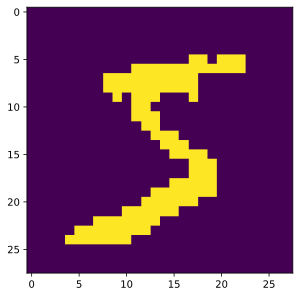

In [251]:
d2l.plt.imshow(test_x.reshape(28, 28))

In [259]:
log_probs = torch.zeros(p_y_len)

for y_i in range(p_y_len):
  likelihood = 0

  for idx, x_i in enumerate(test_x):
    likelihood += torch.log(p_xy[idx, y_i]**x_i * (1 - p_xy[idx, y_i])**(1 - x_i))
  
  prior = p_y[y_i]  
  log_probs[y_i] = likelihood + torch.log(prior)
  

actual_probs = torch.softmax(log_probs, dim=0)
torch.argmax(actual_probs)

tensor(5)

In [269]:
test_flatted_data = mnist_test.data.view(-1, 784).float()
test_flatted_data = (test_flatted_data.data > 127).float()

test_flatted_data.shape

torch.Size([10000, 784])

In [270]:
test_labels = mnist_test.test_labels
test_labels.shape

d:\Documents\anaconda\envs\torch_gpu\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.Size([10000])

In [272]:
log_Pxy = torch.log(p_xy)          # Shape: (784, 10)
log_Pxy_inv = torch.log(1 - p_xy)  # Shape: (784, 10)
log_Py = torch.log(p_y)            # Shape: (10,)

log_likelihood = torch.matmul(test_flatted_data, log_Pxy) + \
                 torch.matmul((1 - test_flatted_data), log_Pxy_inv)

log_probs_all = log_likelihood + log_Py

y_hat = torch.argmax(log_probs_all, dim=1)

accuracy = (y_hat == test_labels).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.2f}%")

Accuracy: 84.27%
